Welcome to you for the best kernel of this competition. Coded by me Sémi Ben Hsan (SBH) .A Free lance Machine Learning Engineer (contact me for a work if want :p ) . This kernel includes all the advanced techniques of Regression
, programmed in a professional way ( The SBH style ) and explained in detail . I am waiting for your votes, opinions and comments ... If you use parts of this notebook in your scripts/notebooks, giving some kind of credit would be very much appreciated :) You can for instance link back to this notebook. Thanks!

0. Import 
1. Utils 

2. Reducing Memory Usage
3. Missing values
4. fillna
5. Drop

  5.1 Correlation matrix

  5.2 Constant features

  5.3 Random Forest selector 

  5.4 PCA 

6. Modeling 

 6.1 GridsearchCV

 6.2 StratifiedKfoldCV train
 
 6.3 Stacking 

0. Import 

In [1]:
import pandas as pd 
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

1. Utils 

Here I present some functions that will be useful for this notebook 
concat_df(train, test) : to concatenate the train and the test 
divide_df(all_data,shape) : to split the train and the test already concatenated 
load(path) : to load the data

In [2]:
def concat_df(train, test):
    df = pd.concat([train,test],ignore_index=True )
    return  df 

In [3]:
def divide_df(all_data,shape):
    train,test = all_data.loc[:shape-1], all_data.loc[shape:].drop(['claim'], axis=1) 
    return train,test 

In [4]:
def load(path) : 
    df = pd.read_csv(path)
    return df 

2. Reducing Memory Usage

In [5]:
train = load('../input/tabular-playground-series-sep-2021/train.csv')
test = load('../input/tabular-playground-series-sep-2021/test.csv')

Here we will iterate through all the columns of a dataframe and modify the data typeto reduce memory usage.        
    

In [6]:
def reduce_mem_usage(df):
   
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [7]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 877.00 MB
Memory usage after optimization is: 262.19 MB
Decreased by 70.1%
Memory usage of dataframe is 448.02 MB
Memory usage after optimization is: 134.60 MB
Decreased by 70.0%


In [8]:
df_all = concat_df(train, test)

3. Missing values

since we can only run a model after checking that our data set does not contain any nan we have to do a quick visualization 

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
def missing_values(df): 
  total = df.isnull().sum().sort_values(ascending=False)
  percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
  f, ax = plt.subplots(figsize=(15, 6))
  plt.xticks(rotation='90')
  sns.barplot(x=missing_data.index, y=missing_data['Percent'])
  plt.xlabel('Features', fontsize=15)
  plt.ylabel('Percent of Missing Values', fontsize=15)
  plt.title('Percentage of Missing Data by Feature', fontsize=15)
  # missing_data.head()
  return (missing_data)

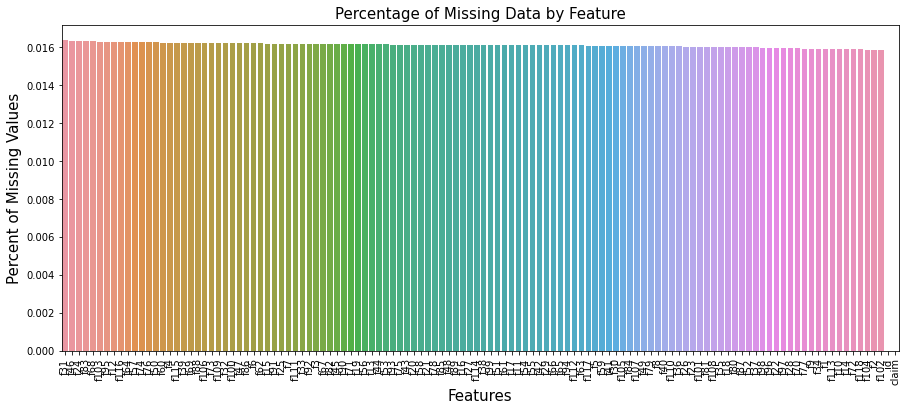

In [10]:
missing_data = missing_values(train)

As shown in the figure, our data set contains several nans. We have to do a filling nans job

4. fillna

Two methods proposed here : 
- SimpleImputer of sklearn 
- Random sampling : consists in filling the nans of each column with values already existing in the considered column 

In [11]:
# from sklearn.impute import SimpleImputer
# import numpy as np
# def Fillna(train,test):
#     imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
#     train = imp_mean.fit_transform(train.drop('claim',axis=1))
#     test = imp_mean.transform(test)
#     return train,test

In [12]:
def Random_sampling(df, variable):
    # extract the random sample to fill the na
    random_sample = df[variable].dropna().sample(df[variable].isnull().sum(), random_state=0) 
    # pandas needs to have the same index in order to merge datasets
    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(), variable] = random_sample


In [13]:
def missing_search (missing_data) : 
    missing_columns = [idx for idx , row in missing_data.iterrows() if row['Percent'] != 0 ]
    return missing_columns

In [14]:
missing_columns = missing_search (missing_data)

In [15]:
def fillna(df_all,missing_columns):
    for column in missing_columns: 
        Random_sampling(df_all,column) 
    return df_all

In [16]:
df_all = fillna(df_all,missing_columns)

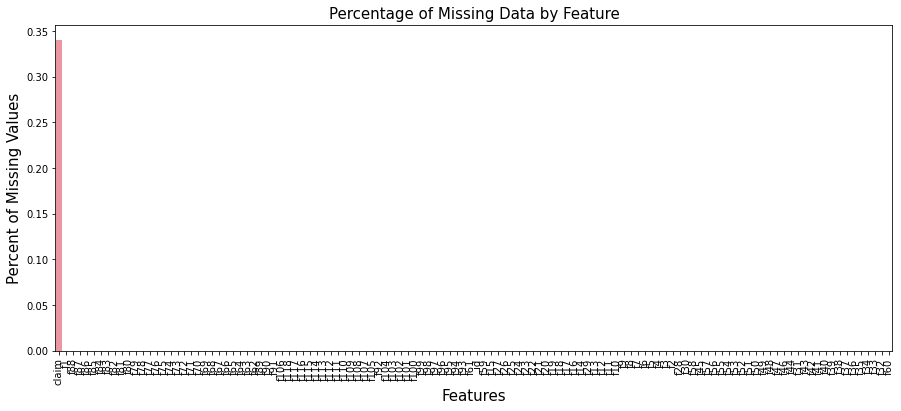

In [17]:
_ = missing_values(df_all)

In [18]:
train, test = divide_df(df_all,train.shape[0])

Here is our pure (clean) data, without any nans to consider 

5. Drop 

Since we have a large space here (120 columns) reducing this space would be an extraordinary idea. Several methods proposed here 

5.1 Correlation matrix


The correlation matrix here is used to study the correlation between different columns. Two correlated columns would be better to keep one and delete one since the second one has no meaning it adds no information and it increases the space for nothing 

In [19]:
def correlation_matrix (df) : 
    corr = df.corr(method='pearson')
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(12, 9))
    sns.heatmap(corr, mask=mask, vmax=1, center=0, annot=True, fmt='.1f',
                square=True, linewidths=.5, cbar_kws={"shrink": .5});
    return corr
    

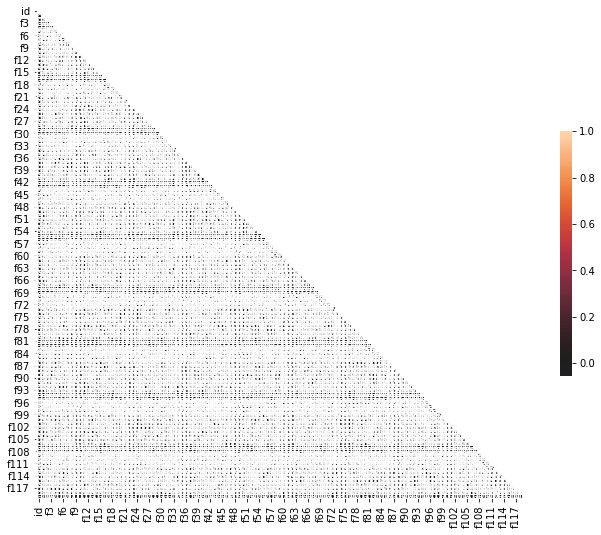

In [20]:
corr  = correlation_matrix (train)


In [21]:
def to_drop_feat_corr (corr,threshold) :
    # Select upper triangle of correlation matrix
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] >threshold )]
    return to_drop 

In [22]:
to_drop = to_drop_feat_corr (corr,0.95)

In [23]:
to_drop

[]

5.2 Constant features

A constant (quasi constant) column has absolutely no added value since it takes the same value for any observation it would be better to delete it. sklearn offers here the VarianceThreshold tool which is used to find the columns that have a variance lower than a certain threshold and delete it 

In [24]:
from sklearn.feature_selection import VarianceThreshold
def constant_features (df,threshold) :  
    sel = VarianceThreshold(threshold=threshold)
    sel.fit(df)  # fit finds the features with zero variance
    to_drop = [x for x in df.columns if x not in df.columns[sel.get_support()]]
    return to_drop 

In [25]:
to_drop = constant_features (train,0.01)

In [26]:
to_drop

['f1', 'f34', 'f45', 'f57', 'f97', 'f107']

In [27]:
# df_all.drop(to_drop,axis=1,inplace=True) 

5.3 Random forest selector 

Random forests are one the most popular machine learning algorithms. They are so successful because they provide in general a good predictive performance, low overfitting and easy interpretability. This interpretability is given by the fact that it is straightforward to derive the importance of each variable on the tree decision. In other words, it is easy to compute how much each variable is contributing to the decision.



To give a better intuition, features that are selected at the top of the trees are in general more important than features that are selected at the end nodes of the trees, as generally the top splits lead to bigger information gains.

I will demonstrate this process using it as follows



In [28]:
import seaborn as sns 
import matplotlib. pyplot as plt
from sklearn.ensemble import RandomForestClassifier
def feature_importance (df) : 
    clf = RandomForestClassifier(n_estimators=1, random_state=0)
    clf.fit(df.drop('claim',axis=1) ,df['claim']) # 'loss' hia label 
    #visualize feature importance
    plt.figure(num=None, figsize=(10,8), dpi=80, facecolor='w', edgecolor='k')
    feat_importances = pd.Series(clf.feature_importances_, index= df.drop('claim',axis=1).columns)
    feat_importances.nlargest(7).plot(kind='barh')
    return feat_importances


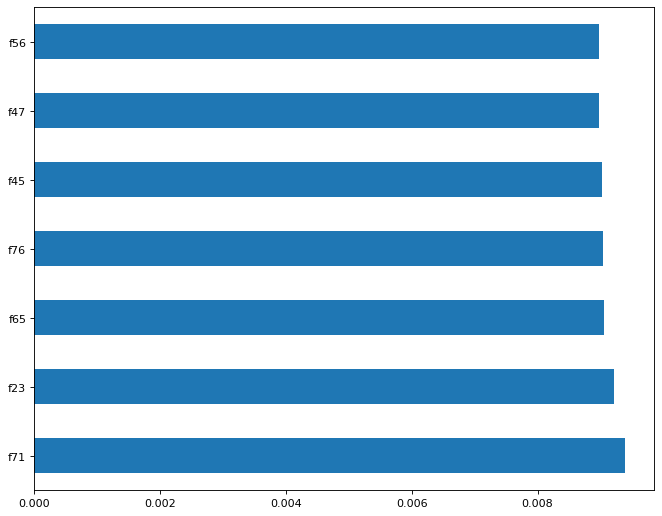

In [29]:
feat_importances = feature_importance (train)

And then you can choose to do the train with the most important features that you choose

5.4 PCA

Dimensionality reduction is way to reduce the complexity of a model and avoid overfitting. There are two main categories of dimensionality reduction: feature selection and feature extraction. Via feature selection, we select a subset of the original features (the past methods ) , whereas in feature extraction (this method ) , we derive information from the feature set to construct a new feature subspace.

In [30]:
from sklearn.decomposition import PCA
def pca_variance_matrix(df) : 
    pca = PCA()
    _ = pca.fit_transform(df.drop('claim',axis=1))
    explained_variance=pca.explained_variance_ratio_
    return explained_variance

explained_variance = pca_variance_matrix(df_all)

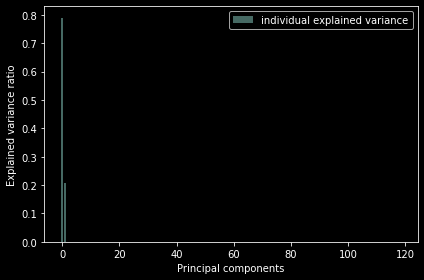

In [31]:
def explained_variance_plot (explained_variance) : 
    with plt.style.context('dark_background'):
        plt.figure(figsize=(6, 4))
        plt.bar(range(explained_variance.shape[0]), explained_variance, alpha=0.5, align='center',label='individual explained variance')
        plt.ylabel('Explained variance ratio')
        plt.xlabel('Principal components')
        plt.legend(loc='best')
        plt.tight_layout()

explained_variance_plot (explained_variance) 

In [32]:
def pca_fitting (nb , df) : 
    pca=PCA(n_components=nb) # ou nb  le nb de dimensions choisis ....
    X_new=pca.fit_transform(df.drop('loss',axis=1))
    return X_new 

In [33]:
# X_new = pca_fitting (df)

In [34]:
train, test = divide_df(df_all,train.shape[0])

6. Modeling

Fasten your belt : The modeling part coded by SBH in an original way ...

6.1 Gridsearch CV

It consists on an Exhaustive search over specified parameter values for an estimator.

Important members are fit, predict.

GridSearchCV implements a “fit” and a “score” method. It also implements “score_samples”, “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” if they are implemented in the estimator used.

The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.

In [35]:
model = CatBoostClassifier() , 
parameters =  {'depth'         : [6,8,10], 
                  'learning_rate' : [0.01, 0.05, 0.1],      
                  'iterations'    : [1000,5000,10000]
                 }, 
cv = 2, 
n_jobs=-1

In [36]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
class GridSearch :
  def __init__(self,train,test) :
    self.data = train
    self.X_train = train.drop('claim',axis=1)
    self.y_train = train['claim']
    self.X_test = test
  def model (self,model) :
    self.model = model
  def parameters (self, parameters) :
    self.parameters = parameters
  def GridSearch (self) :
    self.grid = GridSearchCV(estimator=self.model, param_grid = self.parameters, cv = 5, n_jobs=-1)
  def Gridfit (self) :
    self.grid.fit(np.asarray(self.X_train),np.asarray(self.y_train))
  def finalfit (self) :
    self.grid.best_estimator_.fit(np.asarray(self.X_train),np.asarray(self.y_train))
  def predict(self):
    self.pred = self.grid.best_estimator_.predict(np.asarray(self.X_test))
    return (self.pred)
#   def score(self,label):
#     from sklearn.metrics import mean_absolute_error
#     mean_absolute_error(label,self.pred)


In [37]:
# gridsearch = GridSearch(train,test)
# gridsearch.model(model)
# gridsearch.parameters(parameters)
# gridsearch.GridSearch()
# gridsearch.Gridfit()
# gridsearch.finalfit()
# gridsearch.predict()

6.2 StratifiedKFold_Train 

Stratified K-Folds cross-validator.

Provides train/test indices to split data in train/test sets.

This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

In [38]:
def features_type (df) : 
  numerical = df.dtypes[df.dtypes != "object"].index
  non_num = []
  for x in  list(df.columns) : 
      if x not in numerical : 
          non_num.append(x)
  return numerical , non_num

In [39]:
numerical , non_num = features_type (train)

In [40]:
non_num

[]

In [41]:

class CFG_Catboost :
  SEED = 42
  n_splits = 5
  catboost_params = {'learning_rate':0.05,'iterations':10000,'eval_metric':'Accuracy',
                      'use_best_model' :True,'verbose':100,'random_seed': 0,'loss_function':'MultiClass',
                         'leaf_estimation_method':'Newton'}

  remove_features = ['claim']
  categ_features = non_num
  TARGET_COL = 'claim'

In [42]:
def features_utils (train):
  features_columns = [col for col in train.columns if col not in CFG_Catboost.remove_features]
  return features_columns

In [43]:
features_columns = features_utils (train)

In [44]:
def divide_train (train):
  skf = StratifiedKFold(n_splits=CFG_Catboost.n_splits,shuffle=True, random_state=CFG_Catboost.SEED)
  X , y   = train[features_columns] , train[CFG_Catboost.TARGET_COL]
  return X,y,skf

In [45]:
from sklearn.model_selection import StratifiedKFold
X,y,skf = divide_train (train)

In [46]:
def StratifiedKFold_Train(X,y):
  # oof_cat = np.zeros((train.shape[0],))
  test['target'] = 0
  cat_preds= []
  for fold_, (trn_idx, val_idx) in enumerate(skf.split(X,y)):
      print(50*'-')
      print('Fold:',fold_+1)
      X_train, y_train = X.iloc[trn_idx,:], y[trn_idx] 
      X_test, y_test = X.iloc[val_idx,:], y[val_idx] 
        
      estimator = CatBoostClassifier(**CFG_Catboost.catboost_params)
      estimator.fit(Pool(X_train,y_train,cat_features = CFG_Catboost.categ_features),
                    eval_set = Pool(X_test,y_test,cat_features = CFG_Catboost.categ_features),
                    early_stopping_rounds=200)
      
      # y_pred_val = estimator.predict(X_test)
      # oof_cat[val_idx] = y_pred_val
      y_pred_test = estimator.predict(test[features_columns])
      cat_preds.append(y_pred_test)
      print(50*'-')
      print()
  return cat_preds



In [47]:
from catboost import CatBoostClassifier ,Pool
# cat_preds = StratifiedKFold_Train(X,y)

6.3 Stacking

Stacking was introduced by Wolpert in the paper Stacked Generalization in 1992. It is a method that uses k-fold for training base models which then make predictions on the left out fold. These so-called out of fold predictions are then used to train another model — the meta model — which can use the information produced by the base models to make final predictions.

To implement this functionality we need to first train each base model k times (k…Number of folds) and then use their predictions to train our meta model.

To even get better results we can not only use the predictions of all the base models for  training the meta model but also the initial features. Because of the added model complexity which is caused when adding the input features we should make a boolean parameter to determine whether we want to use input features.

In [48]:
from sklearn.base import BaseEstimator, TransformerMixin, clone, RegressorMixin
from sklearn.model_selection import KFold
import numpy as np


class StackingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5, task_type='classification', use_features_in_secondary=False):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        self.task_type = task_type
        self.use_features_in_secondary = use_features_in_secondary

    def fit(self, X, y):
        """Fit all the models on the given dataset"""
        self.base_models_ = [list() for _ in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)

        # Train cloned base models and create out-of-fold predictions
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred

        if self.use_features_in_secondary:
            self.meta_model_.fit(np.hstack((X, out_of_fold_predictions)), y)
        else:
            self.meta_model_.fit(out_of_fold_predictions, y)

        return self

    def predict(self, X):
        if self.task_type == 'classification':
            meta_features = np.column_stack([[np.argmax(np.bincount(predictions)) for predictions in
                                              np.column_stack([model.predict(X) for model in base_models])]
                                             for base_models in self.base_models_])
        else:
            meta_features = np.column_stack([
                np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
                for base_models in self.base_models_])
        if self.use_features_in_secondary:
            return self.meta_model_.predict(np.hstack((X, meta_features)))
        else:
            return self.meta_model_.predict(meta_features)

    def predict_proba(self, X):
        if self.task_type == 'classification':
            meta_features = np.column_stack([[np.argmax(np.bincount(predictions)) for predictions in
                                              np.column_stack([model.predict(X) for model in base_models])]
                                             for base_models in self.base_models_])
            if self.use_features_in_secondary:
                return self.meta_model_.predict_proba(np.hstack((X, meta_features)))
            else:
                return self.meta_model_.predict_proba(meta_features)

In [49]:
from sklearn.model_selection import KFold, cross_val_score
n_folds = 5 # number of folds
def get_cv_scores(model, X, y, print_scores=True):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X) # create folds
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = kf)) # get rmse
    if print_scores:
        print(f'Root mean squared error: {rmse.mean():.3f} ({rmse.std():.3f})')
    return [rmse]

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pathlib
from scipy import stats
from scipy.stats import norm, skew

from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

import xgboost as xgb
import lightgbm as lgb

lasso_model = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))
rf = RandomForestRegressor()
gbr = GradientBoostingRegressor()
xgb_model = xgb.XGBRegressor()
lgb_model = lgb.LGBMRegressor()
# for model in [lasso_model, rf, gbr, xgb_model, lgb_model]:
#     get_cv_scores(model, X, train.claim)

In [51]:
stacking_model1 = StackingModels([gbr, lgb_model, xgb_model], lasso_model)
# get_cv_scores(stacking_model1, X, y_train);


So choose the best model/combination you want in order to win the competition. 
I am waiting for your upvotes/comments . Do not hesitate to contact me if you have any question 